# 🌟 Giải Mã Thuật Toán: Stability Feature Selection

## 🎯 Mục Đích
Tìm ra các kênh dữ liệu (features) quan trọng nhất và ổn định nhất để dự báo mưa, giải quyết vấn đề **tràn RAM** và **nhiễu ngẫu nhiên**.

## ⚙️ Cấu Hình Chính
* **`N_ITERATIONS = 5`**: Chạy lặp lại thí nghiệm 5 lần để lấy giá trị trung bình, loại bỏ yếu tố may rủi.
* **`PIXELS_PER_IMG = 2000`**: Từ mỗi ảnh gốc (triệu pixel), chỉ lấy ngẫu nhiên **2000 điểm** đại diện để tiết kiệm bộ nhớ.

## 🔄 Quy Trình Hoạt Động (4 Bước)
1.  **Data Alignment (Đồng bộ):** Dùng Regex để khớp thời gian giữa file Radar (Mưa) và file Vệ tinh (Features) dù tên file khác nhau.
2.  **Random Sampling (Lấy mẫu):** Duyệt qua **TOÀN BỘ** kho ảnh. Tại mỗi ảnh, rút ngẫu nhiên 2000 điểm dữ liệu hợp lệ.
3.  **Model Training (Huấn luyện):** Đưa dữ liệu gộp (khoảng 4-5 triệu điểm) vào mô hình **Random Forest** để chấm điểm tầm quan trọng của từng feature.
4.  **Aggregation (Tổng hợp):**
    * Tính **Mean Score** (Trung bình cộng) để xếp hạng.
    * Tính **Std Dev** (Độ lệch chuẩn) để đánh giá độ ổn định của feature qua 5 lần chạy.

## 📊 Kết Quả Đầu Ra
* Biểu đồ **Bar Chart** hiển thị Top Features kèm thanh sai số (Error bar).
* File `Feature_Ranking_Final.csv`: Bảng xếp hạng chi tiết để chọn lọc input cho mô hình AI.

--- BƯỚC 1: QUÉT DỮ LIỆU ---
-> Tìm thấy 34 loại Features.
-> Tổng số file Radar (Label): 2487
-> Sẽ xử lý trên toàn bộ 2487 thời điểm.

--- BẮT ĐẦU CHẠY 5 LẦN (MỖI LẦN DUYỆT HẾT 2487 ẢNH) ---

>> Lần chạy thứ 1 / 5...


Đang đọc file: 100%|██████████| 2487/2487 [00:51<00:00, 48.43it/s] 


   -> Dữ liệu train vòng này: (1768000, 34) (Dòng, Cột)

>> Lần chạy thứ 2 / 5...


Đang đọc file: 100%|██████████| 2487/2487 [00:45<00:00, 54.76it/s] 


   -> Dữ liệu train vòng này: (1768000, 34) (Dòng, Cột)

>> Lần chạy thứ 3 / 5...


Đang đọc file: 100%|██████████| 2487/2487 [00:44<00:00, 56.20it/s] 


   -> Dữ liệu train vòng này: (1768000, 34) (Dòng, Cột)

>> Lần chạy thứ 4 / 5...


Đang đọc file: 100%|██████████| 2487/2487 [00:39<00:00, 63.15it/s] 


   -> Dữ liệu train vòng này: (1768000, 34) (Dòng, Cột)

>> Lần chạy thứ 5 / 5...


Đang đọc file: 100%|██████████| 2487/2487 [00:39<00:00, 62.69it/s] 


   -> Dữ liệu train vòng này: (1768000, 34) (Dòng, Cột)

--- KẾT QUẢ XẾP HẠNG ---
      Mean_Score   Std_Dev
TCW     0.111257  0.006492
I4B     0.070602  0.007509
B04B    0.061137  0.012242
R500    0.057168  0.010994
VSB     0.047828  0.004761
R250    0.047040  0.004935
V250    0.046861  0.019208
WVB     0.044237  0.003457
TCLW    0.041918  0.014983
CIN     0.041257  0.008861
U250    0.037366  0.005729
B05B    0.034759  0.009668
B06B    0.030971  0.005291
B09B    0.030221  0.004218
V850    0.027773  0.004090
PEV     0.022713  0.005897
U850    0.019674  0.003512
KX      0.019516  0.003475
R850    0.019425  0.002730
CAPE    0.018884  0.002789


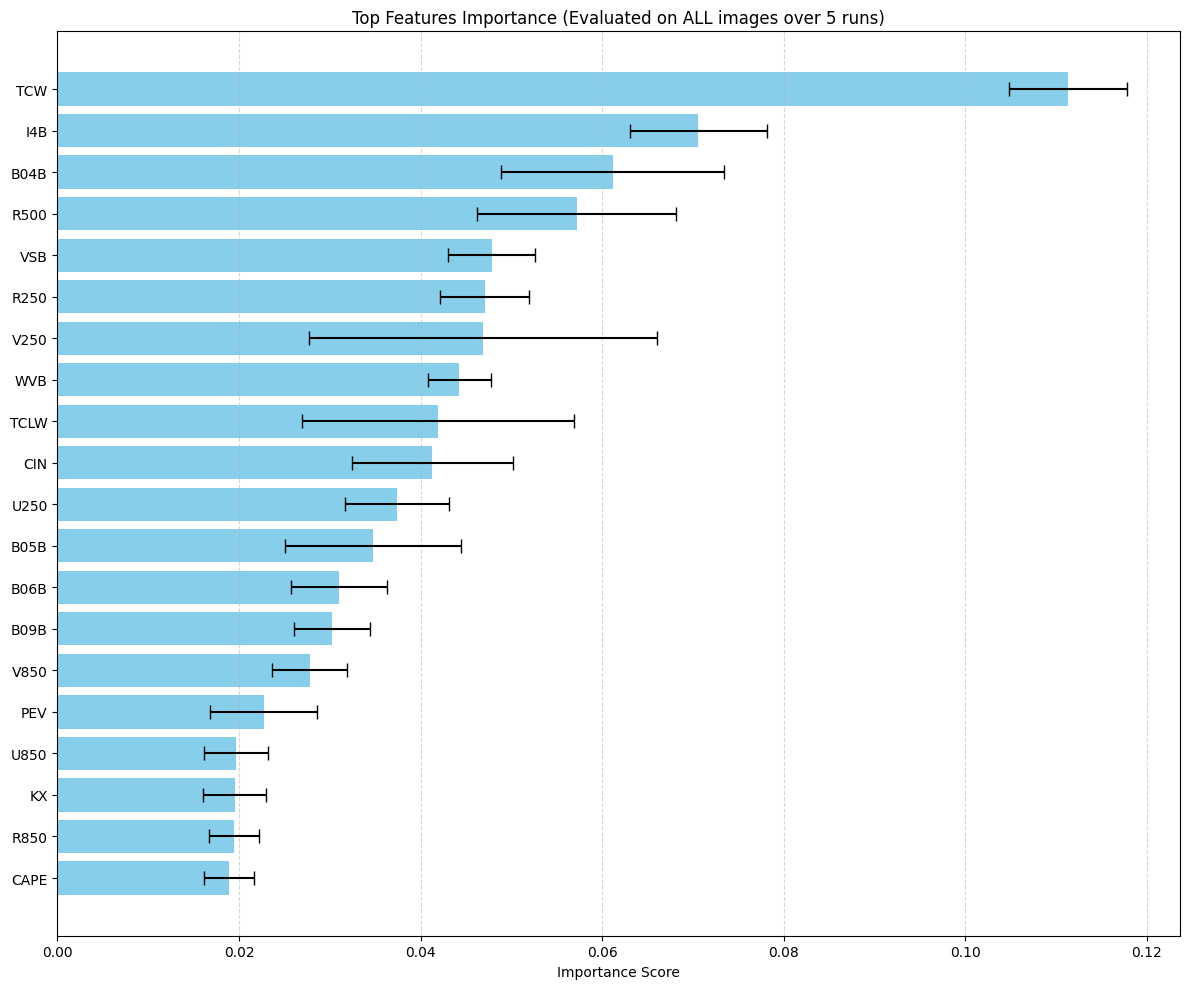

In [9]:
import os
import glob
import re
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

# ================= 1. CẤU HÌNH =================
ROOT_DIR = "../DATA_SV"
LABEL_FOLDER = "Precipitation/Radar"

# THAM SỐ QUAN TRỌNG:
N_ITERATIONS = 5       # Số lần chạy lặp lại thí nghiệm (để lấy trung bình cho chuẩn)
PIXELS_PER_IMG = 2000  # Từ mỗi ảnh, chỉ lấy ngẫu nhiên 2000 điểm pixel (để tránh tràn RAM)

# ================= 2. HÀM XỬ LÝ =================
def extract_datetime_from_filename(path):
    filename = os.path.basename(path)
    # Regex cho các loại tên file của bạn
    m14 = re.search(r"(\d{14})", filename)
    if m14: return pd.to_datetime(m14.group(1), format="%Y%m%d%H%M%S", errors="coerce")

    m_date = re.search(r"(\d{8})", filename)
    m_z = re.search(r"Z(\d{4})", filename)
    if m_date:
        date = m_date.group(1)
        if m_z: return pd.to_datetime(date + m_z.group(1), format="%Y%m%d%H%M", errors="coerce")
        return pd.to_datetime(date, format="%Y%m%d", errors="coerce")
    return pd.NaT

def read_tif_as_array(path):
    try:
        with rasterio.open(path) as src:
            return src.read(1).flatten().astype('float32')
    except: return None

# ================= 3. QUÉT TOÀN BỘ FILE (INDEXING) =================
print("--- BƯỚC 1: QUÉT DỮ LIỆU ---")

# 1. Quét Label
label_map = {}
label_files = glob.glob(os.path.join(ROOT_DIR, LABEL_FOLDER, "**/*.tif"), recursive=True)
for f in label_files:
    dt = extract_datetime_from_filename(f)
    if not pd.isna(dt): label_map[dt] = f

# 2. Quét Features
feature_map = {}
found_features = []
for group in ['ERA5', 'Hima']:
    g_path = os.path.join(ROOT_DIR, group)
    if os.path.exists(g_path):
        for d in os.scandir(g_path):
            if d.is_dir():
                feat_name = d.name
                feature_map[feat_name] = {}
                found_features.append(feat_name)
                # Quét tất cả file trong folder feature đó
                for f in glob.glob(os.path.join(d.path, "**/*.tif"), recursive=True):
                    dt = extract_datetime_from_filename(f)
                    if not pd.isna(dt): feature_map[feat_name][dt] = f

print(f"-> Tìm thấy {len(found_features)} loại Features.")
print(f"-> Tổng số file Radar (Label): {len(label_map)}")

# Lấy danh sách thời gian chung (Intersection)
# Chỉ lấy những thời điểm mà Label có, và Features cũng có sơ sơ
common_times = list(label_map.keys())
print(f"-> Sẽ xử lý trên toàn bộ {len(common_times)} thời điểm.")

# ================= 4. VÒNG LẶP ĐÁNH GIÁ (CHẠY TOÀN BỘ ẢNH) =================
print(f"\n--- BẮT ĐẦU CHẠY {N_ITERATIONS} LẦN (MỖI LẦN DUYỆT HẾT {len(common_times)} ẢNH) ---")

importance_history = pd.DataFrame(index=found_features)

for i in range(N_ITERATIONS):
    print(f"\n>> Lần chạy thứ {i+1} / {N_ITERATIONS}...")

    X_list = []
    y_list = []

    # tqdm tạo thanh loading bar chạy từ 0% đến 100% (tương ứng hết số ảnh)
    for dt in tqdm(common_times, desc="Đang đọc file"):

        # A. Kiểm tra xem thời điểm này có đủ features không
        current_paths = {}
        missing = False
        for fn in found_features:
            if dt in feature_map[fn]:
                current_paths[fn] = feature_map[fn][dt]
            else:
                missing = True; break # Thiếu 1 feature cũng bỏ qua ảnh này

        if missing: continue

        # B. Đọc dữ liệu
        y_img = read_tif_as_array(label_map[dt])
        if y_img is None: continue

        feats_img = []
        err = False
        for fn in found_features:
            arr = read_tif_as_array(current_paths[fn])
            if arr is None: err = True; break
            feats_img.append(arr)

        if err: continue

        # C. Ghép và Lấy mẫu Pixel (Sampling)
        try:
            X_stack = np.column_stack(feats_img)

            # Điều kiện lọc:
            # 1. Label phải có số (ko phải NaN), ko âm, ko quá lớn
            # 2. Features phải có số (ko phải NaN/Inf)
            mask = np.isfinite(y_img) & (y_img >= 0) & (y_img < 10000) & np.all(np.isfinite(X_stack), axis=1)

            if np.sum(mask) > 0:
                indices = np.where(mask)[0]

                # --- ĐÂY LÀ CHỖ QUAN TRỌNG ---
                # Lấy ngẫu nhiên 2000 pixel từ ảnh này
                n_take = min(len(indices), PIXELS_PER_IMG)
                chosen = np.random.choice(indices, n_take, replace=False)

                X_list.append(X_stack[chosen, :])
                y_list.append(y_img[chosen])

        except ValueError:
            continue # Lỗi kích thước ảnh không khớp

    # Kiểm tra xem có dữ liệu không
    if not X_list:
        print("Cảnh báo: Không thu thập được dữ liệu nào trong vòng lặp này.")
        continue

    # Gộp dữ liệu lại để train
    X_train = np.vstack(X_list)
    y_train = np.concatenate(y_list)

    print(f"   -> Dữ liệu train vòng này: {X_train.shape} (Dòng, Cột)")

    # Train Random Forest
    rf = RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1)
    rf.fit(X_train, y_train)

    # Lưu kết quả
    importance_history[f'Run_{i+1}'] = rf.feature_importances_

# ================= 5. KẾT QUẢ CUỐI CÙNG =================
print("\n--- KẾT QUẢ XẾP HẠNG ---")

# Tính trung bình
importance_history['Mean_Score'] = importance_history.mean(axis=1)
importance_history['Std_Dev'] = importance_history.std(axis=1)

# Sắp xếp
final_ranking = importance_history.sort_values(by='Mean_Score', ascending=False)

print(final_ranking[['Mean_Score', 'Std_Dev']].head(20))

# Vẽ biểu đồ
plt.figure(figsize=(12, 10))
top_plot = final_ranking.head(20)
plt.barh(top_plot.index, top_plot['Mean_Score'], xerr=top_plot['Std_Dev'], color='skyblue', capsize=5)
plt.gca().invert_yaxis()
plt.title(f'Top Features Importance (Evaluated on ALL images over {N_ITERATIONS} runs)')
plt.xlabel('Importance Score')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()